In [1]:
import numpy as np

In [2]:
import matplotlib
import matplotlib.pyplot as plt

In [3]:
from nitelite_mapmaker import georeference

# Setup

In [4]:
rng = np.random.default_rng(1425)

# Resampling

## Setup Original

In [5]:
original = rng.uniform(size=(1200,1920))

In [6]:
theta = np.pi / 4.
ll_coords = np.array([1., 2.])

In [16]:
xs_img_frame = np.linspace(0., 10., original.shape[1])
ys_img_frame = np.linspace(0., 10., original.shape[0])
xs_img_frame_mesh, ys_img_frame_mesh = np.meshgrid(xs_img_frame, ys_img_frame)

In [17]:
xs = ll_coords[0] + xs_img_frame_mesh * np.cos(theta) + ys_img_frame_mesh * np.sin(theta)
ys = ll_coords[1] + xs_img_frame_mesh * np.sin(-theta) + ys_img_frame_mesh * np.cos(theta)

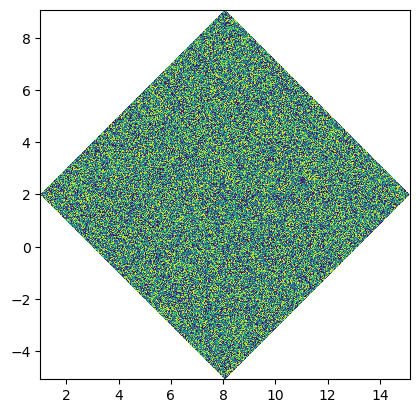

In [18]:
fig = plt.figure()
ax = plt.gca()

ax.pcolormesh(
    xs,
    ys,
    original,
    vmin=0,
    vmax=1,
)

ax.set_aspect('equal')

### Resample

In [19]:
resampled_res = 1.

In [20]:
# Bounds
x_bins = np.arange(xs.min() - resampled_res/2., xs.max() + resampled_res/2., resampled_res)
y_bins = np.arange(ys.min() - resampled_res/2., ys.max() + resampled_res/2., resampled_res)

In [21]:
da_original = (xs_img_frame[1] - xs_img_frame[0]) * (ys_img_frame[1] - ys_img_frame[0]) 

In [22]:
weights = original.flatten() * da_original

In [23]:
# Resample (just histogram)
resampled, _, _ = np.histogram2d(
    xs.flatten(),
    ys.flatten(),
    bins=[x_bins, y_bins],
    weights=weights
)

In [24]:
da_resampled = (x_bins[1] - x_bins[0]) * (y_bins[1] - y_bins[0])
resampled /= da_resampled

In [25]:
xs_resampled = 0.5 * (x_bins[:-1] + x_bins[1:])
ys_resampled = 0.5 * (y_bins[:-1] + y_bins[1:])

## Compare

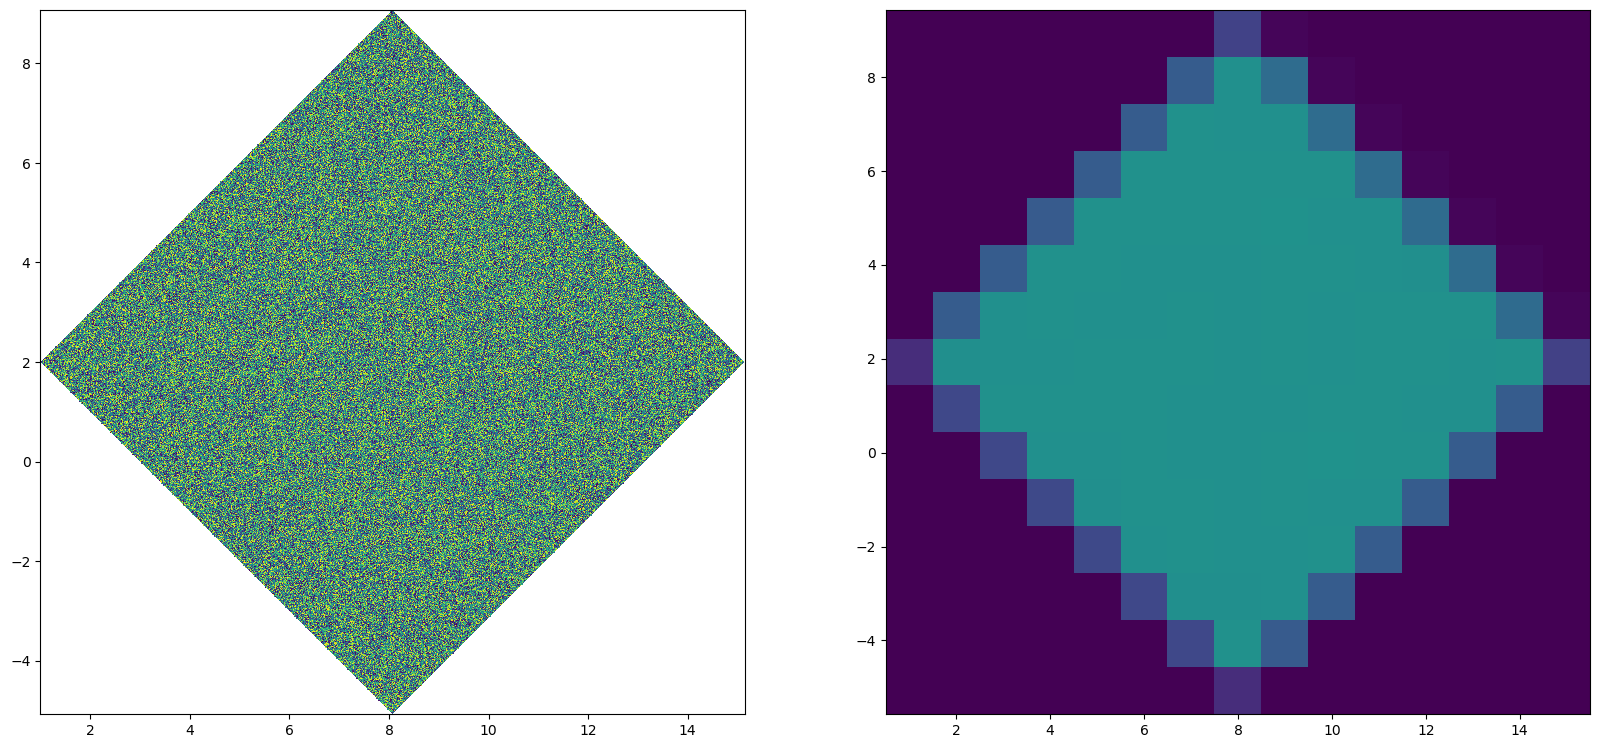

In [26]:
fig = plt.figure(figsize=(20,10))

ax_dict = fig.subplot_mosaic([['original', 'resampled']])

ax = ax_dict['original']
ax.pcolormesh(
    xs,
    ys,
    original,
    vmin=0,
    vmax=1,
)
ax.set_aspect('equal')

ax = ax_dict['resampled']
ax.pcolormesh(
    xs_resampled,
    ys_resampled,
    resampled,
    vmin=0,
    vmax=1,
)
ax.set_aspect('equal')